In [1140]:
import  matplotlib
%matplotlib inline
import matplotlib.pyplot as plt;
import seaborn as sns; sns.set()

import pyprob
from pyprob import Modelprint
from pyprob.distributions import Normal, Uniform, Categorical, Beta

import torch
import numpy as np
import pandas as pd
import math
import random

In [2]:
faces_to_values = {str(i): i for i in range(2,11)}
faces_to_values['A'] = 1
for f in ['K', 'Q', 'J']:
    faces_to_values[f] = 10

In [3]:
class Card:
    def __init__(self, face):
        """
        Value: {1, ..., 10, 11, 12, 13} - 11 is J, 12 is Q, 13 is K
        """
        self.face = face
        self.value = faces_to_values[face]
    
    def __repr__(self):
        return self.face

In [6]:
deck = create_deck(2)

In [930]:
# class Blackjack(Model):
    
#     def __init__(self, num_decks):
#         super().__init__(name='Number game')
#         self.num_decks = num_decks
#         self.deck = self._create_decks()
#         self.cards = {}
    
#     def _create_decks(self):
#         deck = []
#         for _ in range(self.num_decks):
#             for face in faces_to_values.keys():
#                 new_card = Card(face)
#                 deck.append(new_card)

#         return deck
    
    
#     def _deal(self, deck):
#         np.random.shuffle(deck)
        
#         # Dealer
#         dealer_card1 = deck.pop()
#         dealer_card2 = deck.pop()
#         self.cards['dealer'] = [dealer_card1, dealer_card2]
        
#         # Player
#         player_card1 = deck.pop()
#         player_card2 = deck.pop()
#         self.cards['player'] = [player_card1, player_card2]
            
    
#     def compute_prob_draw_value(self, deck):
#         counts = np.zeros(11)
#         for card in deck:
#             counts[card.value] += 1
#         return counts

    
    
#     def forward(self):
#         """
#         Generative sampling process
#         """
#         score = 0  # latent variable to infer
        
#         deck_copy = self.deck.copy()
#         self._deal(deck_copy)
        
#         hidden_cards = self.cards['dealer']
        
#         score += hidden_cards[0].value + hidden_cards[1].value
        
#         for i in range(1,7):
#             if score < 16:
#                 likelihood = Categorical(self.compute_prob_draw_value(self.deck))
#                 new_card = deck_copy.pop()
#                 pyprob.observe(likelihood, name='obs{}'.format(i))
#                 score += new_card.value
#             else:
#                 probs = np.zeros(11)
#                 probs[0] = 1
#                 deterministic = Categorical(probs)
#                 pyprob.observe(deterministic, name='obs{}'.format(i))
        
#         return score
    
    
# model = Blackjack(num_decks=2)
# model_nn = Blackjack(num_decks=2)

In [1359]:
# class Deck():
#     def __init__(self, num_suites):
#         self.value_dict = {i:0 for i in range(11)}
#         self.num_suites = num_suites
        
#         for _ in range(num_suites):
#             for face in faces_to_values.keys():
#                 new_card = Card(face)
#                 self.value_dict[new_card.value] += 1
    
#     def get_value_probs(self):
#         return list(self.value_dict.values())[::]
    
#     def get_value_probs_dict(self):
#         total_sum = sum(list(self.value_dict.values()))
#         return {i:val/float(total_sum) for i,val in self.value_dict.items()}
    
#     def __rep__(self):
#         return self.value_dict
    
#     def draw_card(self):
#         value = int(pyprob.sample(Categorical(self.get_value_probs())))
#         self.value_dict[value] -= 1
#         return value
    
#     def copy(self):
#         temp = Deck(self.num_suites)
#         temp.value_dict = self.value_dict.copy()
#         return temp


# class Blackjack(Model):
    
#     def __init__(self, num_suites):
#         super().__init__(name='Number game')
#         self.num_suites = num_suites
#         self.cards = {}
    
#     def _deal(self, deck):
        
#         # Dealer
#         dealer_card1 = deck.draw_card()
#         dealer_card2 = deck.draw_card()
#         self.cards['dealer'] = [dealer_card1, dealer_card2]
        
#         # Player
#         player_card1 = deck.draw_card()
#         player_card2 = deck.draw_card()
#         self.cards['player'] = [player_card1, player_card2]
        
#     def forward_game(self):
#         """
#         Generative sampling process
#         """                
        
#         deck = Deck(self.num_suites)
#         self._deal(deck)
        
#         score = sum(self.cards['dealer'])
        
#         for i in range(1,7):
#             if score < 16:
#                 likelihood = Categorical(deck.get_value_probs())
#                 new_card = deck.draw_card()
#                 self.cards['dealer'].append(new_card)
#                 pyprob.observe(likelihood, name='obs{}'.format(i))
#                 score += new_card
#             else:
#                 probs = np.zeros(11)
#                 probs[0] = 1
#                 deterministic = Categorical(probs)
#                 pyprob.observe(deterministic, name='obs{}'.format(i))
        
#         return deck, self.cards['player'], self.cards['dealer'], score
            
    
#     def forward(self):
#         """
#         Generative sampling process
#         """                
        
#         deck = Deck(self.num_suites)
#         self._deal(deck)
        
#         score = sum(self.cards['dealer'])
        
#         for i in range(1,7):
#             if score < 16:
#                 likelihood = Categorical(deck.get_value_probs())
#                 new_card = deck.draw_card()
#                 pyprob.observe(likelihood, name='obs{}'.format(i))
#                 score += new_card
#             else:
#                 probs = np.zeros(11)
#                 probs[0] = 1
#                 deterministic = Categorical(probs)
#                 pyprob.observe(deterministic, name='obs{}'.format(i))
        
#         return score
    
    
# model = Blackjack(num_suites=1)
# model_nn = Blackjack(num_suites=1)

In [1753]:
class Deck():
    def __init__(self, num_suites):
        self.value_dict = {i:0 for i in range(6)}
        self.num_suites = num_suites
        
        for _ in range(num_suites):
            for value in [1,2,3,4,5]:
                self.value_dict[value] += 1
    
    def get_value_probs(self):
        return list(self.value_dict.values())[::]
    
    def get_value_probs_dict(self):
        total_sum = sum(list(self.value_dict.values()))
        return {i:val/float(total_sum) for i,val in self.value_dict.items()}
    
    def __rep__(self):
        return self.value_dict
    
    def draw_card(self):
        probs = self.get_value_probs().copy()
        sample = pyprob.sample(Categorical(probs))
        value = int(sample)
        self.value_dict[value] -= 1

#             raise Error('Should not have been sampled')


        return value
    
    def copy(self):
        temp = Deck(self.num_suites)
        temp.value_dict = self.value_dict.copy()
        return temp


class Blackjack(Model):
    
    def __init__(self, num_suites):
        super().__init__(name='Number game')
        self.num_suites = num_suites
        self.cards = {}
    
    def _deal(self, deck):
        
        # Dealer
        dealer_card1 = deck.draw_card()
#         dealer_card2 = deck.draw_card()
        self.cards['dealer'] = [dealer_card1]
        
#         # Player
#         player_card1 = deck.draw_card()
#         player_card2 = deck.draw_card()
#         self.cards['player'] = [player_card1, player_card2]
        
#     def forward_game(self):
#         """
#         Generative sampling process
#         """                
        
#         deck = Deck(self.num_suites)
#         self._deal(deck)
        
#         score = sum(self.cards['dealer'])
        
#         for i in range(1,7):
#             if score < 8:
#                 likelihood = Categorical(deck.get_value_probs())
#                 new_card = deck.draw_card()
#                 self.cards['dealer'].append(new_card)
#                 pyprob.observe(likelihood, name='obs{}'.format(i))
#                 score += new_card
#             else:
#                 probs = np.zeros(6)
#                 probs[0] = 1
#                 deterministic = Categorical(probs)
#                 pyprob.observe(deterministic, name='obs{}'.format(i))
        
#         return deck, self.cards['player'], self.cards['dealer'], score
            
    
    def forward(self):
        """
        Generative sampling process
        """                
        
        deck = Deck(self.num_suites)
        self._deal(deck)
#         print(deck.get_value_probs())
        
        score = sum(self.cards['dealer'])
        print('Dealer Hidden Card', score)
        
        

        probs = deck.get_value_probs()
        likelihood = Categorical(probs)
        pyprob.observe(likelihood, name='obs1')
        new_card = deck.draw_card()
        print('new card', new_card)
        score += new_card
            
            
            
        if score < 7:
            probs = deck.get_value_probs()
            likelihood = Categorical(probs.copy())
            pyprob.observe(likelihood, name='obs2')
            new_card = deck.draw_card()
            print('new card', new_card)
            score += new_card
            
        else:
            probs = np.zeros(6)
            probs[0] = 1
            likelihood = Categorical(probs.copy())
            pyprob.observe(likelihood, name='obs2')

            
            
            
        if score < 7:
            probs = deck.get_value_probs()
            likelihood = Categorical(probs.copy())
            pyprob.observe(likelihood, name='obs3')
            new_card = deck.draw_card()
            print('new card', new_card)
            score += new_card
            
        else:
            probs = np.zeros(6)
            probs[0] = 1
            likelihood = Categorical(probs)
            pyprob.observe(likelihood, name='obs3')


        print('score', score)


        return sum(self.cards['dealer'])
    
    
model = Blackjack(num_suites=1)
model_nn = Blackjack(num_suites=1)

In [1754]:
model.forward()

Dealer Hidden Card 5
new card 4
score 9


5

# Prior on Dealer Score

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
Dealer Hidden Card 3
new card 2
new card 1
new card 5
score 11
Dealer Hidden Card 4
new card 3
score 7
Dealer Hidden Card 4
new card 2
new card 3
score 9
Dealer Hidden Card 1
new card 5
new card 4
score 10
Dealer Hidden Card 2
new card 3
new card 4
score 9
Dealer Hidden Card 4
new card 1
new card 2
score 7
Dealer Hidden Card 3
new card 4
score 7
Dealer Hidden Card 3
new card 5
score 8
Dealer Hidden Card 5
new card 3
score 8
Dealer Hidden Card 3
new card 1
new card 4
score 8
Dealer Hidden Card 1
new card 2
new card 5
score 8
Dealer Hidden Card 3
new card 4
score 7
Dealer Hidden Card 2
new card 1
new card 4
score 7
Dealer Hidden Card 5
new card 4
score 9
Dealer Hidden Card 2
new card 3
new card 4
score 9
Dealer Hidden Card 1
new card 4
new card 5
score 10
Dealer Hidden Card 4
new card 2
new card 3
score 9
Dealer Hidden Card 5
new card 3
score 8
Dealer Hidden Card 4
new card 2
new card 1
score 7
Dealer Hidden Card 4

new card 3
new card 5
score 9
Dealer Hidden Card 1
new card 4
new card 3
score 8
Dealer Hidden Card 5
new card 2
score 7
Dealer Hidden Card 2
new card 5
score 7
Dealer Hidden Card 3
new card 5
score 8
Dealer Hidden Card 5
new card 1
new card 2
score 8
Dealer Hidden Card 5
new card 3
score 8
Dealer Hidden Card 4
new card 5
score 9
Dealer Hidden Card 5
new card 2
score 7
Dealer Hidden Card 5
new card 3
score 8
Dealer Hidden Card 3
new card 2
new card 5
score 10
Dealer Hidden Card 3
new card 1
new card 5
score 9
Dealer Hidden Card 5
new card 3
score 8
Dealer Hidden Card 5
new card 2
score 7
Dealer Hidden Card 1
new card 3
new card 2
new card 4
score 10
Dealer Hidden Card 3
new card 2
new card 4
score 9
Dealer Hidden Card 1
new card 5
new card 2
score 8
Dealer Hidden Card 2
new card 5
score 7
Dealer Hidden Card 1
new card 2
new card 4
score 7
Dealer Hidden Card 3
new card 2
new card 1
new card 4
score 10
Dealer Hidden Card 4
new card 1
new card 2
score 7
Dealer Hidden Card 5
new card 3
sco

new card 1
new card 3
score 9
Dealer Hidden Card 1
new card 5
new card 4
score 10
Dealer Hidden Card 1
new card 2
new card 5
score 8
Dealer Hidden Card 4
new card 3
score 7
Dealer Hidden Card 4
new card 2
new card 5
score 11
Dealer Hidden Card 3
new card 5
score 8
Dealer Hidden Card 3
new card 2
new card 1
new card 4
score 10
Dealer Hidden Card 3
new card 2
new card 1
new card 5
score 11
Dealer Hidden Card 3
new card 4
score 7
Dealer Hidden Card 1
new card 2
new card 5
score 8
Dealer Hidden Card 5
new card 3
score 8
Dealer Hidden Card 2
new card 3
new card 1
new card 5
score 11
Dealer Hidden Card 4
new card 2
new card 3
score 9
Dealer Hidden Card 3
new card 1
new card 2
new card 5
score 11
Dealer Hidden Card 2
new card 5
score 7
Dealer Hidden Card 300:02 | #######------------- |  364/1000 | 289.78       
new card 5
score 8
Dealer Hidden Card 2
new card 3
new card 5
score 10
Dealer Hidden Card 5
new card 4
score 9
Dealer Hidden Card 3
new card 4
score 7
Dealer Hidden Card 2
new card 3
n

score 8
Dealer Hidden Card 3
new card 2
new card 4
score 9
Dealer Hidden Card 4
new card 3
score 7
Dealer Hidden Card 5
new card 4
score 9
Dealer Hidden Card 5
new card 1
new card 4
score 10
Dealer Hidden Card 2
new card 1
new card 3
new card 5
score 11
Dealer Hidden Card 1
new card 4
new card 2
score 7
Dealer Hidden Card 2
new card 4
new card 3
score 9
Dealer Hidden Card 3
new card 5
score 8
Dealer Hidden Card 4
new card 2
new card 3
score 9
Dealer Hidden Card 4
new card 2
new card 1
score 7
Dealer Hidden Card 100:01 | ###########--------- |  531/1000 | 262.78       
new card 5
new card 2
score 8
Dealer Hidden Card 2
new card 5
score 7
Dealer Hidden Card 3
new card 1
new card 4
score 8
Dealer Hidden Card 5
new card 1
new card 4
score 10
Dealer Hidden Card 3
new card 4
score 7
Dealer Hidden Card 5
new card 1
new card 3
score 9
Dealer Hidden Card 1
new card 3
new card 2
new card 4
score 10
Dealer Hidden Card 5
new card 2
score 7
Dealer Hidden Card 3
new card 1
new card 5
score 9
Dealer 

new card 5
score 9
Dealer Hidden Card 2
new card 1
new card 5
score 8
Dealer Hidden Card 5
new card 4
score 9
Dealer Hidden Card 1
new card 3
new card 2
new card 5
score 11
Dealer Hidden Card 1
new card 4
new card 2
score 7
Dealer Hidden Card 1
new card 4
new card 5
score 10
Dealer Hidden Card 2
new card 4
new card 5
score 11
Dealer Hidden Card 2
new card 3
new card 1
new card 5
score 11
Dealer Hidden Card 3
new card 2
new card 4
score 9
Dealer Hidden Card 2
new card 5
score 7
Dealer Hidden Card 2
new card 5
score 7
Dealer Hidden Card 1
new card 5
new card 2
score 8
Dealer Hidden Card 4
new card 5
score 9
Dealer Hidden Card 3
new card 4
score 7
Dealer Hidden Card 500:01 | ##############------ |  707/1000 | 255.03       
new card 4
score 9
Dealer Hidden Card 3
new card 4
score 7
Dealer Hidden Card 4
new card 2
new card 1
score 7
Dealer Hidden Card 3
new card 4
score 7
Dealer Hidden Card 5
new card 2
score 7
Dealer Hidden Card 3
new card 2
new card 4
score 9
Dealer Hidden Card 5
new card

score 7
Dealer Hidden Card 3
new card 1
new card 4
score 8
Dealer Hidden Card 5
new card 1
new card 2
score 8
Dealer Hidden Card 1
new card 4
new card 2
score 7
Dealer Hidden Card 3
new card 1
new card 4
score 8
Dealer Hidden Card 4
new card 2
new card 3
score 9
Dealer Hidden Card 2
new card 3
new card 1
new card 4
score 10
Dealer Hidden Card 2
new card 3
new card 1
new card 5
score 11
Dealer Hidden Card 4
new card 2
new card 5
score 11
Dealer Hidden Card 3
new card 1
new card 5
score 9
Dealer Hidden Card 300:00 | ##################-- |  876/1000 | 247.90       
new card 1
new card 2
new card 4
score 10
Dealer Hidden Card 3
new card 2
new card 5
score 10
Dealer Hidden Card 5
new card 3
score 8
Dealer Hidden Card 4
new card 2
new card 1
score 7
Dealer Hidden Card 2
new card 4
new card 1
score 7
Dealer Hidden Card 5
new card 4
score 9
Dealer Hidden Card 4
new card 5
score 9
Dealer Hidden Card 4
new card 1
new card 2
score 7
Dealer Hidden Card 2
new card 3
new card 1
new card 4
score 10
D

/Users/theo/anaconda3/envs/csis/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  """


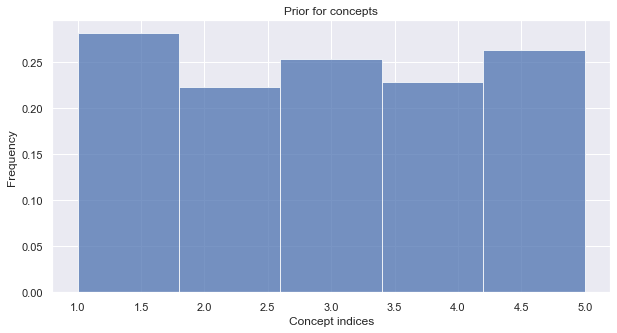

In [1739]:
prior = model.prior_results(num_traces=1000)
prior.plot_histogram(show=False, alpha=0.75, label='empirical prior', bins=5)
plt.title('Prior for concepts')
plt.xlabel('Concept indices')
plt.show()

# Dealer Score Posterior - Importance Sampling

In [1746]:
observations = {'obs1':4, 'obs2':3, 'obs3':0}

Time spent  | Time remain.| Progress             | Trace   | Traces/sec
Dealer Hidden Card 5
new card 3
score 8
Dealer Hidden Card 4
new card 1
new card 3
score 8
Dealer Hidden Card 4
new card 5
score 9
Dealer Hidden Card 5
new card 4
score 9
Dealer Hidden Card 1
new card 5
new card 2
score 8
Dealer Hidden Card 5
new card 2
score 7
Dealer Hidden Card 4
new card 1
new card 3
score 8
Dealer Hidden Card 3
new card 1
new card 2
new card 4
score 10
Dealer Hidden Card 1
new card 5
new card 2
score 8
Dealer Hidden Card 5
new card 2
score 7
Dealer Hidden Card 1
new card 2
new card 3
new card 5
score 11
Dealer Hidden Card 4
new card 1
new card 3
score 8
Dealer Hidden Card 3
new card 2
new card 4
score 9
Dealer Hidden Card 1
new card 5
new card 4
score 10
Dealer Hidden Card 1
new card 3
new card 5
score 9
Dealer Hidden Card 1
new card 3
new card 4
score 8
Dealer Hidden Card 4
new card 2
new card 5
score 11
Dealer Hidden Card 4
new card 5
score 9
Dealer Hidden Card 4
new card 1
new card 2
score 7

Text(0.5, 1.0, 'Importance Sampling Inferred Posterior')

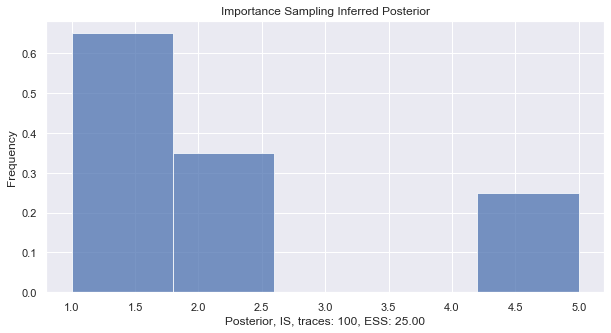

In [1756]:
posterior_many = model.posterior_results(
                    num_traces=100, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING, # specify which inference engine to use
                    observe=observations) # assign values to the observed values
posterior_many.plot_histogram(show=False, alpha=0.75, bins=5, label='inferred posterior')
plt.title('Importance Sampling Inferred Posterior')

In [1606]:
list(posterior_many)

[4, 1, 5]

In [1717]:
combined = posterior_many.combine_duplicates()
hypothesis = [(combined[i], np.exp(combined._get_log_weight(i).item())) for i in range(combined._length) if np.exp(combined._get_log_weight(i).item()) > 0.00001]
sorted(hypothesis, key=lambda x: x[1], reverse=True)

[(3, 0.47999983510349725), (4, 0.3599998177235519), (2, 0.15999991325082966)]

### Many Samples

In [1752]:
posterior_many = model.posterior_results(
                    num_traces=50000, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.LIGHTWEIGHT_METROPOLIS_HASTINGS, # specify which inference engine to use
                    observe=observations) # assign values to the observed values
posterior_many.plot_histogram(show=False, alpha=0.75, bins=99, label='inferred posterior')
plt.title('Importance Sampling Inferred Posterior')

Dealer Hidden Card 1
new card 5
new card 2
score 8
Time spent  | Time remain.| Progress             | Trace       | Accepted|Smp reuse| Traces/sec
Dealer Hidden Card 1
new card 5
new card 2
score 8
Dealer Hidden Card 1
new card 5
new card 4
score 10
Dealer Hidden Card 1
new card 5
new card 4
score 10
Dealer Hidden Card 1
new card 5
new card 4
score 10
Dealer Hidden Card 1
new card 4
new card 4
score 9
Dealer Hidden Card 1
new card 5
new card 4
score 10
Dealer Hidden Card 1
new card 2
new card 4
score 7
Dealer Hidden Card 1
new card 2
new card 3
new card 4
score 10
Dealer Hidden Card 1
new card 5
new card 4
score 10
Dealer Hidden Card 4
new card 5
score 9
Dealer Hidden Card 1
new card 5
new card 2
score 8
Dealer Hidden Card 1
new card 5
new card 3
score 9
Dealer Hidden Card 1
new card 5
new card 3
score 9
Dealer Hidden Card 1
new card 5
new card 3
score 9
Dealer Hidden Card 1
new card 4
new card 3
score 8
Dealer Hidden Card 1
new card 4
new card 2
score 7
Dealer Hidden Card 1
new card 4

RuntimeError: invalid multinomial distribution (encountering probability entry < 0)

### Few Samples

Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 500/500 | 492.99       


Text(0.5, 1.0, 'Importance Sampling Inferred Posterior')

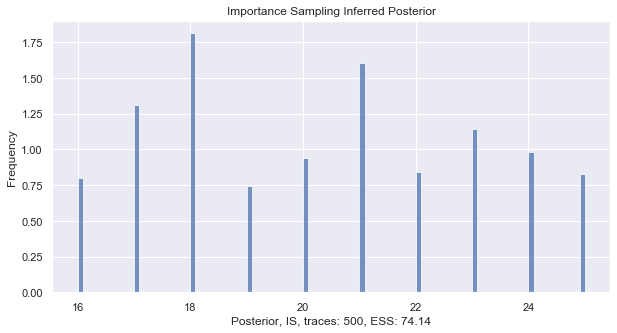

In [1164]:
posterior_few = model.posterior_results(
                    num_traces=500, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING, # specify which inference engine to use
                    observe=observations) 
posterior_few.plot_histogram(show=False, alpha=0.75, bins=99, label='inferred posterior')
plt.title('Importance Sampling Inferred Posterior')
# plt.savefig('images/importance_sampling_inferred_posterior_200.png')

# Inference Compilation

In [1479]:
model.reset_inference_network()
model.learn_inference_network(num_traces=10000,
                              observe_embeddings={'obs1': {'dim' : 32},
                                                  'obs2': {'dim' : 32},
                                                  'obs3': {'dim' : 32},
                                                  'obs4': {'dim' : 32}},
                              inference_network=pyprob.InferenceNetwork.LSTM)
model._inference_network

Creating new inference network...
Observable obs1: reshape not specified, using shape torch.Size([]).
Observable obs1: using embedding dim torch.Size([32]).
Observable obs1: observe embedding not specified, using the default FEEDFORWARD.
Observable obs1: embedding depth not specified, using the default 2.
Observable obs2: reshape not specified, using shape torch.Size([]).
Observable obs2: using embedding dim torch.Size([32]).
Observable obs2: observe embedding not specified, using the default FEEDFORWARD.
Observable obs2: embedding depth not specified, using the default 2.
Observable obs3: reshape not specified, using shape torch.Size([]).
Observable obs3: using embedding dim torch.Size([32]).
Observable obs3: observe embedding not specified, using the default FEEDFORWARD.
Observable obs3: embedding depth not specified, using the default 2.
Observable obs4: reshape not specified, using shape torch.Size([]).
Observable obs4: using embedding dim torch.Size([32]).
Observable obs4: observe

InferenceNetworkLSTM(
  (_layers_observe_embedding): ModuleDict(
    (obs1): EmbeddingFeedForward(
      (_layers): ModuleList(
        (0): Linear(in_features=1, out_features=16, bias=True)
        (1): Linear(in_features=16, out_features=32, bias=True)
      )
    )
    (obs2): EmbeddingFeedForward(
      (_layers): ModuleList(
        (0): Linear(in_features=1, out_features=16, bias=True)
        (1): Linear(in_features=16, out_features=32, bias=True)
      )
    )
    (obs3): EmbeddingFeedForward(
      (_layers): ModuleList(
        (0): Linear(in_features=1, out_features=16, bias=True)
        (1): Linear(in_features=16, out_features=32, bias=True)
      )
    )
    (obs4): EmbeddingFeedForward(
      (_layers): ModuleList(
        (0): Linear(in_features=1, out_features=16, bias=True)
        (1): Linear(in_features=16, out_features=32, bias=True)
      )
    )
  )
  (_layers_proposal): ModuleDict(
    (22__forward___deal__draw_card__sample__Categorical(len_probs:6)__1): Proposa

In [ ]:
model._inference_network

Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 107.87       


Text(0.5, 1.0, 'Inference Network Importance Sampling Inferred Posterior')

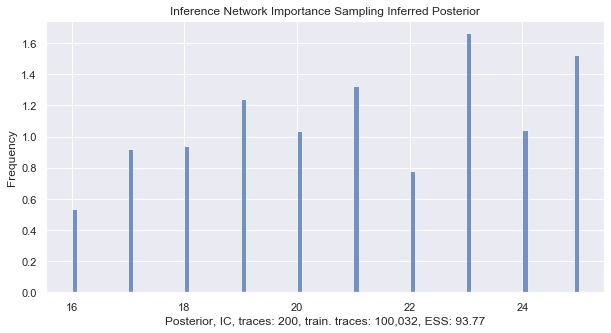

In [1214]:
posterior_nn = model.posterior_results(num_traces=200, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, # specify which inference engine to use
                    observe=observations) # assign values to the observed values
posterior_nn.plot_histogram(show=False, bins=99, alpha=0.75, label='inferred posterior')
plt.title('Inference Network Importance Sampling Inferred Posterior')

In [615]:
combined = posterior_2000.combine_duplicates()
hypothesis = [(combined[i], np.exp(combined._get_log_weight(i).item())) for i in range(combined._length) if np.exp(combined._get_log_weight(i).item()) > 0.00001]
sorted(hypothesis, key=lambda x: x[1], reverse=True)

[(22, 0.11799401758414134),
 (20, 0.10910054738622853),
 (17, 0.10540218620806194),
 (18, 0.10262842575734707),
 (16, 0.10223220303156243),
 (19, 0.09809358692543273),
 (23, 0.09598027415694763),
 (24, 0.09237005439960745),
 (25, 0.09148949296478279),
 (21, 0.08470921158588812)]

# Simulating Games

## My strategy

In [771]:
def calc_EV(x, deck, dealerDistribution):
    
    EV_table = {}
    
    def calc_EV_helper(x, deck, dealerDistribution):

        if x in EV_table:
            return EV_table[x]
                
        if x > 21:
            EV_table[x] = ((1 - dealerDistribution.p_bust) * (-1), False)
            return EV_table[x]
        
        elif x <= 21:
            
            EV_stay_dealer_bust = dealerDistribution.p_bust * (1)
            EV_stay_dealer_no_bust = (1 - dealerDistribution.p_bust) * (dealerDistribution.p_less_than(x) * (1) + dealerDistribution.p_greater_than(x) * (-1))
            EV_stay = EV_stay_dealer_bust + EV_stay_dealer_no_bust
            
            EV_hit = 0
            for val,prob in deck.get_value_probs_dict().items():
                if prob > 0:
                    deck_copy = deck.copy()
                    deck_copy.value_dict[val] -= 1
                    EV_hit += prob * calc_EV_helper(x + val, deck_copy, dealerDistribution)[0]

        if EV_hit > EV_stay:
            EV_table[x] = (EV_hit, True)
        else:
            EV_table[x] = (EV_stay, False)
        return EV_table[x]
    
    return calc_EV_helper(x, deck, dealerDistribution)
            
# deck = Deck(4)
# for i in range(1,30):
    
#     EV, play = calc_EV(i, deck, dist)
#     print(i, EV, play)

In [1226]:
posterior

In [1241]:
combined = posterior.combine_duplicates()
posterior_probs = {combined[i]:np.exp(combined._get_log_weight(i).item()) for i in range(combined._length) if np.exp(combined._get_log_weight(i).item()) > 0.00001}
sum(posterior_probs.values())

0.9999978963169368

In [1248]:
deck.get_value_probs_dict().values()

dict_values([0.0, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.0625, 0.08333333333333333, 0.0625, 0.0625, 0.3125])

In [1250]:
deck.get_value_probs()

[0, 4, 4, 4, 4, 4, 3, 4, 3, 3, 15]

## Infer Dealer Distribution

In [1194]:
class DealerDistribution:
    
    def __init__(self, posterior):
        self.posterior = posterior
        self.probs = {}
        self.p_bust = 0
        print(self.probs)
        combined = posterior.combine_duplicates()
        posterior_probs = {combined[i]:np.exp(combined._get_log_weight(i).item()) for i in range(combined._length) if np.exp(combined._get_log_weight(i).item()) > 0.00001}
        for key, prob in posterior_probs.items():
            if key <= 21:
                self.probs[key] = prob
            else:
                self.p_bust += prob

    def p_less_than(self, x):
        p = 0
        for key,prob in self.probs.items():
            if key < x:
                p += prob
        return p
    
    def p_greater_than(self, x):
        p = 0
        for key,prob in self.probs.items():
            if key > x:
                p += prob
        return p
    
    def plot(self):
        self.posterior.plot_histogram(show=False, alpha=0.75, bins=99, label='inferred posterior')
        plt.title('Importance Sampling Inferred Posterior')
        return

# dist = DealerDistribution(hypothesis)
# print(dist.p_bust)
# dist.probs

In [1215]:
def infer_dealer_score(dealer_cards, num_traces, use_nn=False):

    observations = {}
    print(dealer_cards)
    for i in range(2,8):
        if i < len(dealer_cards):
            observations['obs{}'.format(i-1)] = dealer_cards[i]
        else:
            observations['obs{}'.format(i-1)] = 0
    print(observations)

    if use_nn:
        posterior = model.posterior_results(num_traces=num_traces, # the number of samples estimating the posterior
                            inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, # specify which inference engine to use
                            observe=observations) # assign values to the observed values
    else:
        posterior = model.posterior_results(
                            num_traces=num_traces, # the number of samples estimating the posterior
                            inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING, # specify which inference engine to use
                            observe=observations) 
        
    dealer_posterior = DealerDistribution(posterior)
    return dealer_posterior

In [1224]:
infer_dealer_score(dealer_cards, 200, True)

[6, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 144.95       
{}


## Simulate n Games

In [1251]:
def play(deck, player_cards, dealer_cards, dealer_dist):
    score = sum(player_cards)
    EV, should_hit = calc_EV(score, deck, dealer_dist)
    while should_hit:
        new_card = deck.draw_card()
#         print(new_card)
        score += new_card
        EV, should_hit = calc_EV(score, deck, dealer_dist)
        
#     print("Final Score: {}".format(score))
    return score

def payout(player_score, dealer_score):
    if player_score > 21:
        if dealer_score > 21:
            return 0
        else:
            return -1
    else:
        if dealer_score > 21 or (player_score > dealer_score):
            return 1
        elif player_score < dealer_score:
            return -1
        elif player_score == dealer_score:
            return 0
    raise Error('Should not get here')

def simulate_k_days(k, n, dealer_dist_prior, infer_dealer_dist=None):

    day_wealth = []
    for day in range(k):

        print('Day {}'.format(day))
        wealth = 0

        for i in range(n):

            try:
                deck, player_cards, dealer_cards, score = model.forward_game()
            #     print(player_cards, dealer_cards)
                if infer_dealer_dist == 'nn_is':
                    print('got here')
                    inferred_dealer_dist = infer_dealer_score(dealer_cards, 200, True)
                elif infer_dealer_dist == 'is':
                    inferred_dealer_dist = infer_dealer_score(dealer_cards, 200, False)
                else:
                    inferred_dealer_dist = dealer_dist_prior
                player_score = play(deck, player_cards, dealer_cards, inferred_dealer_dist)
                dealer_score = sum(dealer_cards)
                wealth += payout(player_score, dealer_score)
            except:
                pass

        day_wealth.append(wealth)
    print('Mean wealth: {}'.format(np.mean(np.array(day_wealth))))
    print('Median wealth: {}'.format(np.median(np.array(day_wealth))))
    return day_wealth

Day 0


Day 1


Day 2


Day 3


Day 4


Day 5


Day 6


Day 7


Day 8


Day 9


Mean wealth: -2.9
Median wealth: -3.5


(array([ 1.,  2.,  3., 12.,  8., 11., 18., 13.,  9.,  5.]),
 array([-24. , -20.2, -16.4, -12.6,  -8.8,  -5. ,  -1.2,   2.6,   6.4,
         10.2,  14. ]),
 <a list of 10 Patch objects>)

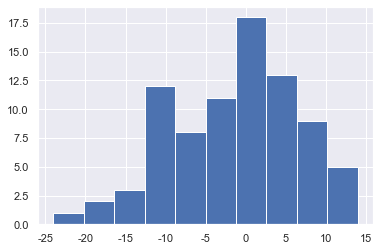

In [1203]:
day_wealth_prior = simulate_k_days(10, 50, dealer_dist_prior)
plt.hist(day_wealth)

Day 0
got here
[5, 5, 8]
{'obs1': 8, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 134.42       
{}
got here
[10, 8]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 174.99       
{}
got here
[10, 5, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 143.16       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 177.12       
{}
got here
[2, 10, 3, 7]
{'obs1': 3, 'obs2': 7, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 126.31       
{}
got here
[1, 7, 5, 10]
{'obs1': 5, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 123.79       
{}
got here
[3, 6, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 144.56       
{}
got here
[3, 10, 1, 5]
{'obs1': 1, 'obs2': 5, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 117.65       
{}
got here
[7, 6, 8]
{'obs1': 8, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 143.65       
{}
got here
[10, 2, 5]
{'obs1': 5, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 145.66       
{}
got here
[2, 10, 2, 6]
{'obs1': 2, 'obs2': 6, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 123.15       
{}
got here
[3, 10, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 141.90       
{}
got here
[6, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 175.86       
{}
got here
[7, 6, 4]
{'obs1': 4, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 135.01       
{}
got here
[6, 2, 9]
{'obs1': 9, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 141.88       
{}
got here
[5, 4, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 141.06       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 174.76       
{}
got here
[10, 3, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 136.16       
{}
got here
[6, 4, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 143.29       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 175.74       
{}
got here
[4, 7, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 142.23       
{}


got here
[1, 10, 3, 6]
{'obs1': 3, 'obs2': 6, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 124.57       
{}
got here
[4, 3, 9]
{'obs1': 9, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 121.50       
{}
got here
[7, 5, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 131.43       
{}
got here
[6, 9, 3]
{'obs1': 3, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 131.60       
{}
got here
[3, 10, 3]
{'obs1': 3, 'obs2': 0, 'obs3': 0

0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 142.06       
{}
got here
[9, 8]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 158.77       
{}
got here
[2, 6, 9]
{'obs1': 9, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 134.69       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 172.72       
{}
got here
[2, 3, 10, 6]
{'obs1': 10, 'obs2': 6, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:02 | 0d:00:00:00 | #################### | 200/200 | 93.20        
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 170.41       
{}
got here
[1, 8, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 139.81       
{}
got here
[10, 5, 4]
{'obs1': 4, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 143.74       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 175.61       
{}
got here
[10, 7]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 175.75       
{}
got here
[1, 10, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 140.75       
{}
got here
[1, 4, 6, 2, 10]
{'obs1': 6, 'obs2': 2, 'obs3': 10, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 110.72       
{}
got here
[3, 5, 6, 10]
{'obs1': 6, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 118.42       
{}
got here
[9, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 176.00       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 176.31       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 176.10       
{}
got here
[8, 5, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 143.37       
{}
got here
[10, 7]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 174.83       
{}
got here
[10, 4, 5]
{'obs1': 5, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 140.82       
{}
got here
[3, 6, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 145.14       
{}
got here
[10, 8]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 175.65       
{}
got here
[10, 2, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 144.80       
{}
got here
[8, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 173.00       
{}
got here
[1, 9, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 137.74       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 154.10       
{}
Day 1
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 142.29       
{}
got here
[9, 2, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 119.00       
{}
got here
[10, 4, 3]
{'obs1': 3, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 126.38       
{}
got here
[6, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 159.05       
{}
got here
[1, 4, 9, 10]
{'obs1': 9, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 107.85       
{}
got here
[8, 2, 3, 10]
{'obs1': 3, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 100.53       
{}
got here
[8, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 142.00       
{}
got here
[8, 7, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:02 | 0d:00:00:00 | #################### | 200/200 | 79.37       
{}
got here
[6, 9, 8]
{'obs1': 8, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 140.59       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 130.81       
{}
got here
[3, 10, 8]
{'obs1': 8, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 126.22       
{}
got here
[6, 7, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 127.10       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 156.41       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 160.61       
{}
got here
[7, 5, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 130.77       
{}
got here
[1, 5, 8, 10]
{'obs1': 8, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 117.96       
{}
got here
[3, 8, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 130.60       
{}
got here
[1, 3, 3, 8, 10]
{'obs1': 3, 'obs2': 8, 'obs3': 10, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 100.80       
{}
got here
[5, 9, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 137.37       
{}
got here
[10, 6]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 157.10       
{}
got here
[4, 1, 7, 10]
{'obs1': 7, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 113.56       
{}
got here
[1, 6, 3, 9]
{'obs1': 3, 'obs2': 9, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 105.65       
{}
got here
[10, 3, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.96       
{}
got here
[9, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 144.32       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 168.98       
{}
got here
[7, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 173.38       
{}
got here
[1, 6, 5, 10]
{'obs1': 5, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 111.97       
{}
got here
[8, 7, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 145.69       
{}
got here
[8, 6, 1, 3]
{'obs1': 1, 'obs2': 3, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 115.35       
{}
got here
[5, 2, 3, 4, 10]
{'obs1': 3, 'obs2': 4, 'obs3': 10, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 108.05       
{}
got here
[10, 3, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 141.36       
{}
got here
[7, 8, 3]
{'obs1': 3, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.79       
{}
got here
[10, 2, 4]
{'obs1': 4, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.25       
{}
got here
[2, 1, 7, 10]
{'obs1': 7, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 127.14       
{}
got here
[6, 7, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 128.49       
{}
got here
[3, 5, 8]
{'obs1': 8, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 104.94       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 153.04       
{}
got here
[5, 9, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 138.03       
{}
got here
[4, 10, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 129.35       
{}
got here
[10, 4, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 125.03       
{}
got here
[10, 8]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 156.81       
{}
got here
[10, 5, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 120.08       
{}
got here
[2, 5, 2, 10]
{'obs1': 2, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 116.17       
{}
got here
[6, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 175.69       
{}
got here
[4, 4, 5, 8]
{'obs1': 5, 'obs2': 8, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 107.48       
{}
got here
[9, 2, 5]
{'obs1': 5, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 141.72       
{}
got here
[4, 5, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 139.00       
{}
got here
[5, 5, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 151.54       
{}
got here
[1, 3, 1, 2, 5, 8]
{'obs1': 1, 'obs2': 2, 'obs3': 5, 'obs4': 8, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 119.48       
{}
got here
[10, 6]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 185.07       
{}
Day 2
got here
[1, 10, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 153.69       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 185.71       
{}
got here
[10, 7]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 183.63       
{}
got here
[7, 5, 8]
{'obs1': 8, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 153.07       
{}
got here
[10, 5, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 155.58       
{}
got here
[2, 10, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 154.00       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 173.02       
{}
got here
[3, 1, 7, 8]
{'obs1': 7, 'obs2': 8, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 119.38       
{}
got here
[7, 3, 5, 3]
{'obs1': 5, 'obs2': 3, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 118.10       
{}
got here
[3, 6, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 143.24       
{}
got here
[10, 9]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 159.89       
{}
got here
[8, 9]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 159.74       
{}
got here
[2, 7, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 138.10       
{}
got here
[6, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 174.10       
{}
got here
[3, 10, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 131.33       
{}
got here
[8, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 175.74       
{}
got here
[10, 6]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 162.37       
{}
got here
[5, 3, 4, 6]
{'obs1': 4, 'obs2': 6, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 103.68       
{}
got here
[9, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 155.67       
{}
got here
[3, 10, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 134.92       
{}
got here
[4, 8, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.21       
{}
got here
[7, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.45       
{}
got here
[10, 7]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 180.37       
{}
got here
[4, 10, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.62       
{}
got here
[7, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.80       
{}
got here
[9, 5, 2]
{'obs1': 2, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.04       
{}
got here
[1, 9, 3, 10]
{'obs1': 3, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 128.53       
{}
got here
[2, 10, 1, 9]
{'obs1': 1, 'obs2': 9, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 120.79       
{}
got here
[4, 2, 8, 7]
{'obs1': 8, 'obs2': 7, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 127.86       
{}
got here
[4, 7, 5]
{'obs1': 5, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.27       
{}
got here
[8, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.73       
{}
got here
[6, 6, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 144.75       
{}
got here
[3, 10, 8]
{'obs1': 8, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.23       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.13       
{}
got here
[9, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 180.62       
{}
got here
[2, 10, 9]
{'obs1': 9, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 145.16       
{}
got here
[9, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 178.64       
{}
got here
[7, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 178.89       
{}
got here
[10, 7]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 156.74       
{}
got here
[6, 6, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 125.75       
{}
got here
[8, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 156.32       
{}
got here
[7, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 171.06       
{}
got here
[4, 3, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.45       
{}
got here
[1, 7, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 143.96       
{}
got here
[9, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.49       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.59       
{}
got here
[2, 5, 6, 10]
{'obs1': 6, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 127.45       
{}
got here
[4, 8, 3, 10]
{'obs1': 3, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 125.63       
{}
got here
[3, 4, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 145.14       
{}
got here
[8, 7, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 120.04       
{}
Day 3
got here
[1, 4, 10, 10]
{'obs1': 10, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 109.92       
{}
got here
[7, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 167.70       
{}
got here
[5, 4, 8]
{'obs1': 8, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 142.18       
{}
got here
[6, 3, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 142.40       
{}
got here
[3, 5, 6, 10]
{'obs1': 6, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 128.43       
{}
got here
[6, 2, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.68       
{}
got here
[4, 7, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.37       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 180.10       
{}
got here
[10, 6]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 175.65       
{}
got here
[6, 3, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 138.94       
{}
got here
[1, 2, 10, 10]
{'obs1': 10, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 125.55       
{}
got here
[2, 7, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.72       
{}
got here
[10, 7]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.37       
{}
got here
[4, 7, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 139.41       
{}
got here
[8, 3, 4, 4]
{'obs1': 4, 'obs2': 4, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 107.55       
{}
got here
[9, 4, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 142.22       
{}
got here
[10, 9]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.00       
{}
got here
[10, 8]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 180.36       
{}
got here
[5, 10, 1]
{'obs1': 1, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.80       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.90       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 166.00       
{}
got here
[10, 6]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.02       
{}
got here
[2, 10, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 128.28       
{}
got here
[4, 8, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.56       
{}
got here
[3, 2, 2, 10]
{'obs1': 2, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 125.32       
{}
got here
[5, 1, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.35       
{}
got here
[10, 6]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 168.40       
{}
got here
[2, 10, 4]
{'obs1': 4, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 143.64       
{}
got here
[10, 2, 8]
{'obs1': 8, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.30       
{}
got here
[8, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 177.95       
{}
got here
[10, 6]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 177.05       
{}
got here
[8, 1, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 138.16       
{}
got here
[5, 8, 1, 10]
{'obs1': 1, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 126.20       
{}
got here
[2, 8, 3, 6]
{'obs1': 3, 'obs2': 6, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 124.85       
{}
got here
[3, 2, 10, 9]
{'obs1': 10, 'obs2': 9, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 125.18       
{}
got here
[2, 10, 9]
{'obs1': 9, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.19       
{}
got here
[10, 2, 2, 6]
{'obs1': 2, 'obs2': 6, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 127.87       
{}
got here
[5, 10, 8]
{'obs1': 8, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.32       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 178.65       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 181.43       
{}
got here
[6, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 180.01       
{}
got here
[8, 5, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 139.07       
{}
got here
[10, 4, 5]
{'obs1': 5, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.85       
{}
got here
[8, 9]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 178.97       
{}
got here
[10, 7]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 180.04       
{}
got here
[1, 4, 10, 7]
{'obs1': 10, 'obs2': 7, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 127.52       
{}
got here
[6, 2, 5, 10]
{'obs1': 5, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 125.56       
{}
got here
[6, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.11       
{}
got here
[6, 8, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.97       
{}
got here
[10, 1, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 144.57       
{}
Day 4
got here
[10, 9]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.73       
{}
got here
[8, 3, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.45       
{}
got here
[5, 3, 7, 10]
{'obs1': 7, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 119.10       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.01       
{}
got here
[5, 8, 9]
{'obs1': 9, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 141.24       
{}
got here
[10, 2, 1, 8]
{'obs1': 1, 'obs2': 8, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 126.04       
{}
got here
[10, 1, 5]
{'obs1': 5, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.10       
{}
got here
[10, 5, 4]
{'obs1': 4, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 149.15       
{}
got here
[10, 2, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.16       
{}
got here
[10, 6]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.46       
{}
got here
[10, 3, 3]
{'obs1': 3, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.29       
{}
got here
[9, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 175.85       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 178.59       
{}
got here
[8, 7, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 137.15       
{}
got here
[6, 1, 2, 5, 10]
{'obs1': 2, 'obs2': 5, 'obs3': 10, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
got here
[5, 8, 9]
{'obs1': 9, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.39       
{}
got here
[9, 9]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 177.63       
{}
got here
[1, 4, 10, 7]
{'obs1': 10, 'obs2': 7, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 125.87       
{}
got here
[7, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 172.06       
{}
got here
[3, 10, 3]
{'obs1': 3, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.13       
{}
got here
[10, 9]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 175.37       
{}
got here
[8, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 178.42       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 180.82       
{}
got here
[2, 5, 4, 10]
{'obs1': 4, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 125.70       
{}
got here
[10, 3, 2, 6]
{'obs1': 2, 'obs2': 6, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 123.98       
{}
got here
[3, 2, 9, 10]
{'obs1': 9, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 125.16       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 180.23       
{}
got here
[10, 8]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 177.13       
{}
got here
[2, 3, 10, 7]
{'obs1': 10, 'obs2': 7, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 126.67       
{}
got here
[8, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.60       
{}
got here
[7, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 176.22       
{}
got here
[3, 1, 10, 10]
{'obs1': 10, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 126.31       
{}
got here
[1, 8, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 127.29       
{}
got here
[5, 1, 3, 9]
{'obs1': 3, 'obs2': 9, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 121.69       
{}
got here
[2, 10, 3, 10]
{'obs1': 3, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 127.83       
{}
got here
[1, 10, 3, 4]
{'obs1': 3, 'obs2': 4, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 123.44       
{}
got here
[5, 4, 6, 1]
{'obs1': 6, 'obs2': 1, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 132.76       
{}
got here
[9, 4, 1, 10]
{'obs1': 1, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 131.69       
{}
got here
[3, 10, 5]
{'obs1': 5, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 152.82       
{}
got here
[7, 2, 4, 7]
{'obs1': 4, 'obs2': 7, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 130.59       
{}
got here
[10, 5, 4]
{'obs1': 4, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 152.91       
{}
got here
[6, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 184.85       
{}
got here
[2, 8, 4, 1, 10]
{'obs1': 4, 'obs2': 1, 'obs3': 10, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 119.53       
{}
got here
[6, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 185.75       
{}
got here
[8, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 166.83       
{}
got here
[10, 8]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 171.98       
{}
got here
[8, 9]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 166.02       
{}
got here
[10, 3, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 145.69       
{}
got here
[10, 4, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 140.16       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 173.91       
{}
Day 5
got here
[10, 6]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 173.24       
{}
got here
[3, 5, 6, 7]
{'obs1': 6, 'obs2': 7, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 125.40       
{}
got here
[1, 10, 9]
{'obs1': 9, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 141.91       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 178.17       
{}
got here
[8, 5, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 149.51       
{}
got here
[5, 10, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 145.61       
{}
got here
[1, 10, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 138.17       
{}
got here
[8, 6, 3]
{'obs1': 3, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 145.61       
{}
got here
[3, 7, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.96       
{}
got here
[8, 1, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.04       
{}
got here
[10, 7]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 178.56       
{}
got here
[5, 10, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 142.23       
{}


got here
[3, 7, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 145.94       
{}
got here
[3, 10, 5]
{'obs1': 5, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 140.33       
{}
got here
[8, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 172.30       
{}
got here
[9, 6, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.68       
{}
got here
[7, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 178.38       
{}
got here
[2, 5, 1, 4, 2, 6]
{'obs1': 1, 'obs2': 4, 'obs3': 2, 'obs4': 6, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 108.70       
{}
got here
[1, 10, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.84       
{}
got here
[10, 8]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 178.50       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 175.90       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.73       
{}
got here
[10, 4, 8]
{'obs1': 8, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.22       
{}
got here
[10, 4, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.92       
{}
got here
[3, 2, 5, 1, 7]
{'obs1': 5, 'obs2': 1, 'obs3': 7, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 111.53       
{}
got here
[10, 1, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.39       
{}
got here
[1, 10, 2, 1, 6]
{'obs1': 2, 'obs2': 1, 'obs3': 6, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 113.30       
{}
got here
[5, 10, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 139.89       
{}
got here
[10, 1, 3, 10]
{'obs1': 3, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 124.62       
{}
got here
[8, 1, 4, 10]
{'obs1': 4, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 127.03       
{}
got here
[5, 2, 3, 10]
{'obs1': 3, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 124.83       
{}
got here
[2, 10, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 144.11       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.38       
{}
got here
[4, 2, 8, 10]
{'obs1': 8, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 126.96       
{}
got here
[7, 4, 9]
{'obs1': 9, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.03       
{}
got here
[8, 3, 4, 10]
{'obs1': 4, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 127.43       
{}
got here
[9, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 162.79       
{}
got here
[10, 4, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 136.84       
{}
got here
[1, 8, 9]
{'obs1': 9, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.29       
{}
got here
[9, 8]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.97       
{}
got here
[8, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.77       
{}
got here
[3, 10, 2, 6]
{'obs1': 2, 'obs2': 6, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 126.01       
{}
got here
[10, 1, 9]
{'obs1': 9, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.23       
{}
got here
[10, 7]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 180.31       
{}
got here
[1, 4, 9, 5]
{'obs1': 9, 'obs2': 5, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 112.99       
{}
got here
[7, 4, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 144.58       
{}
got here
[2, 1, 10, 7]
{'obs1': 10, 'obs2': 7, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 126.44       
{}
got here
[1, 7, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.46       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 168.00       
{}
got here
[5, 10, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.45       
{}
Day 6
got here
[7, 6, 5]
{'obs1': 5, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 139.56       
{}
got here
[6, 7, 3]
{'obs1': 3, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 151.49       
{}
got here
[2, 6, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 151.29       
{}
got here
[10, 4, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 153.40       
{}
got here
[10, 2, 5]
{'obs1': 5, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 154.09       
{}
got here
[2, 4, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 153.65       
{}
got here
[9, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 176.41       
{}
got here
[5, 10, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.72       
{}
got here
[3, 9, 3, 10]
{'obs1': 3, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 132.10       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 170.47       
{}
got here
[8, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.90       
{}
got here
[6, 1, 5, 7]
{'obs1': 5, 'obs2': 7, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 127.41       
{}
got here
[6, 4, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.08       
{}
got here
[10, 8]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 181.37       
{}
got here
[3, 5, 4, 8]
{'obs1': 4, 'obs2': 8, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 127.62       
{}
got here
[6, 5, 1, 10]
{'obs1': 1, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 126.21       
{}
got here
[3, 10, 4]
{'obs1': 4, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.68       
{}
got here
[1, 2, 10, 10]
{'obs1': 10, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 125.89       
{}
got here
[3, 7, 2, 8]
{'obs1': 2, 'obs2': 8, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 128.10       
{}
got here
[7, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 166.08       
{}
got here
[2, 8, 1, 10]
{'obs1': 1, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 122.19       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.32       
{}
got here
[4, 5, 2, 7]
{'obs1': 2, 'obs2': 7, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 127.47       
{}
got here
[10, 8]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 181.88       
{}
got here
[6, 7, 5]
{'obs1': 5, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 145.15       
{}
got here
[10, 9]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 181.48       
{}
got here
[7, 4, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.21       
{}
got here
[10, 5, 4]
{'obs1': 4, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.74       
{}
got here
[3, 2, 2, 10]
{'obs1': 2, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 125.40       
{}
got here
[1, 7, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.05       
{}
got here
[5, 10, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 142.45       
{}
got here
[2, 3, 10, 9]
{'obs1': 10, 'obs2': 9, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
got here
[5, 10, 4]
{'obs1': 4, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 154.67       
{}
got here
[7, 9]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 184.80       
{}
got here
[2, 2, 6, 10]
{'obs1': 6, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 130.35       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 182.72       
{}
got here
[8, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 185.73       
{}
got here
[10, 7]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 186.19       
{}
got here
[6, 5, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 145.98       
{}
got here
[10, 6]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 182.87       
{}
got here
[7, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 185.22       
{}
got here
[10, 7]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 185.81       
{}
got here
[4, 6, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 140.95       
{}
got here
[5, 10, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.59       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 158.73       
{}
got here
[6, 1, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.69       
{}
got here
[8, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 178.50       
{}
got here
[7, 3, 4, 10]
{'obs1': 4, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 123.43       
{}
got here
[10, 4, 2]
{'obs1': 2, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 140.43       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 175.34       
{}
Day 7
got here
[9, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 174.72       
{}
got here
[3, 10, 8]
{'obs1': 8, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 131.93       
{}
got here
[1, 9, 8]
{'obs1': 8, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 125.94       
{}
got here
[2, 4, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 135.84       
{}
got here
[9, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 180.69       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.20       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.88       
{}
got here
[7, 2, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.16       
{}
got here
[8, 1, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.29       
{}
got here
[1, 10, 1, 8]
{'obs1': 1, 'obs2': 8, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 125.49       
{}
got here
[7, 2, 9]
{'obs1': 9, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 145.99       
{}
got here
[2, 2, 10, 10]
{'obs1': 10, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


got here
[8, 5, 9]
{'obs1': 9, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 145.61       
{}
got here
[8, 4, 4]
{'obs1': 4, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.54       
{}
got here
[3, 1, 7, 10]
{'obs1': 7, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 120.13       
{}
got here
[4, 5, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.79       
{}
got here
[9, 4, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.94       
{}
got here
[9, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 180.24       
{}
got here
[9, 5, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.96       
{}
got here
[5, 10, 8]
{'obs1': 8, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 142.33       
{}
got here
[5, 7, 4]
{'obs1': 4, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.19       
{}
got here
[5, 4, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.79       
{}
got here
[4, 2, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.35       
{}
got here
[10, 7]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 178.94       
{}
got here
[6, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 178.37       
{}
got here
[5, 10, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 137.91       
{}
got here
[7, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.71       
{}
got here
[1, 6, 9]
{'obs1': 9, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.99       
{}
got here
[10, 3, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.24       
{}
got here
[9, 6, 8]
{'obs1': 8, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.93       
{}
got here
[7, 8, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 149.32       
{}
got here
[10, 7]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 180.73       
{}
got here
[7, 4, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 149.65       
{}
got here
[8, 5, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.03       
{}
got here
[5, 10, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.36       
{}
got here
[6, 3, 4, 10]
{'obs1': 4, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 127.60       
{}
got here
[2, 2, 10, 10]
{'obs1': 10, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 120.09       
{}
got here
[10, 5, 9]
{'obs1': 9, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.74       
{}
got here
[10, 4, 5]
{'obs1': 5, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.33       
{}
got here
[10, 1, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.34       
{}
got here
[3, 6, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 145.77       
{}
got here
[10, 6]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 180.16       
{}
got here
[8, 5, 4]
{'obs1': 4, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.18       
{}
got here
[10, 2, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.79       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 181.18       
{}
got here
[9, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.67       
{}
got here
[2, 8, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 145.67       
{}
got here
[10, 5, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 134.00       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.56       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 178.94       
{}
Day 8
got here
[5, 9, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.07       
{}
got here
[7, 3, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.85       
{}
got here
[7, 8, 3]
{'obs1': 3, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.30       
{}
got here
[8, 1, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.66       
{}
got here
[4, 6, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.64       
{}
got here
[1, 10, 1, 7]
{'obs1': 1, 'obs2': 7, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 128.17       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.45       
{}
got here
[5, 4, 8]
{'obs1': 8, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 144.66       
{}
got here
[9, 5, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 144.64       
{}
got here
[10, 1, 8]
{'obs1': 8, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 149.96       
{}
got here
[4, 5, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.54       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 175.94       
{}
got here
[8, 5, 8]
{'obs1': 8, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 144.61       
{}
got here
[10, 3, 8]
{'obs1': 8, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.96       
{}
got here
[4, 9, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.01       
{}
got here
[6, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 178.77       
{}
got here
[1, 2, 3, 10]
{'obs1': 3, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 127.28       
{}
got here
[10, 9]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 180.04       
{}
got here
[3, 4, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 143.35       
{}


got here
[4, 10, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 144.35       
{}
got here
[9, 5, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.79       
{}
got here
[10, 8]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 177.69       
{}
got here
[4, 10, 3]
{'obs1': 3, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 150.10       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.58       
{}
got here
[5, 6, 4, 10]
{'obs1': 4, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 127.87       
{}
got here
[10, 7]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 180.53       
{}
got here
[10, 2, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.40       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.70       
{}
got here
[10, 7]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 180.81       
{}
got here
[8, 9]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 180.07       
{}
got here
[9, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 168.59       
{}
got here
[10, 2, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.55       
{}
got here
[8, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 180.83       
{}
got here
[10, 9]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.08       
{}
got here
[10, 2, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.44       
{}
got here
[7, 1, 3, 10]
{'obs1': 3, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 124.23       
{}
got here
[1, 7, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.12       
{}
got here
[5, 10, 3]
{'obs1': 3, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 140.77       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 171.47       
{}
got here
[8, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.64       
{}
got here
[5, 6, 4, 10]
{'obs1': 4, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 125.14       
{}
got here
[6, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 166.14       
{}
got here
[5, 10, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.08       
{}
got here
[8, 6, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.61       
{}
got here
[4, 5, 5, 8]
{'obs1': 5, 'obs2': 8, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 126.36       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 177.37       
{}
got here
[3, 10, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 144.01       
{}
got here
[5, 2, 3, 6]
{'obs1': 3, 'obs2': 6, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 127.07       
{}
got here
[6, 9, 1]
{'obs1': 1, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.34       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 178.11       
{}
Day 9
got here
[10, 5, 2]
{'obs1': 2, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 143.98       
{}
got here
[10, 5, 1]
{'obs1': 1, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.63       
{}
got here
[5, 8, 1, 6]
{'obs1': 1, 'obs2': 6, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 116.16       
{}
got here
[5, 7, 4]
{'obs1': 4, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.49       
{}
got here
[10, 5, 3]
{'obs1': 3, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.78       
{}
got here
[10, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 177.64       
{}
got here
[10, 9]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 174.21       
{}
got here
[10, 4, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.71       
{}
got here
[2, 10, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 145.06       
{}
got here
[7, 4, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.62       
{}
got here
[6, 1, 6, 8]
{'obs1': 6, 'obs2': 8, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 127.31       
{}
got here
[4, 4, 9]
{'obs1': 9, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 145.82       
{}
got here
[3, 1, 8, 9]
{'obs1': 8, 'obs2': 9, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 120.05       
{}
got here
[9, 4, 8]
{'obs1': 8, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 146.89       
{}
got here
[10, 6]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.79       
{}
got here
[9, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 178.77       
{}
got here
[4, 2, 1, 10]
{'obs1': 1, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 108.66       
{}
got here
[7, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 108.15       
{}
got here
[6, 1, 2, 10]
{'obs1': 2, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:02 | 0d:00:00:00 | #################### | 200/200 | 81.81        
{}
got here
[10, 2, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 132.44       
{}
got here
[8, 9]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 155.75       
{}
got here
[2, 9, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 129.25       
{}
got here
[4, 9, 1, 3]
{'obs1': 1, 'obs2': 3, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 116.61       
{}
got here
[6, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 163.91       
{}
got here
[3, 7, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.99       
{}
got here
[5, 10, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 132.05       
{}
got here
[7, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 158.29       
{}
got here
[7, 2, 1, 9]
{'obs1': 1, 'obs2': 9, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 125.57       
{}
got here
[2, 2, 5, 4, 10]
{'obs1': 5, 'obs2': 4, 'obs3': 10, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 111.02       
{}
got here
[7, 4, 6]
{'obs1': 6, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 138.93       
{}
got here
[5, 3, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 120.91       
{}
got here
[7, 4, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 138.32       
{}
got here
[8, 3, 4, 10]
{'obs1': 4, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 124.48       
{}
got here
[10, 8]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 175.83       
{}
got here
[3, 10, 3]
{'obs1': 3, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 110.43       
{}
got here
[1, 1, 6, 10]
{'obs1': 6, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 103.69       
{}
got here
[5, 10, 7]
{'obs1': 7, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 135.95       
{}
got here
[10, 5, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 138.55       
{}
got here
[5, 7, 9]
{'obs1': 9, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 143.76       
{}
got here
[10, 1, 9]
{'obs1': 9, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 147.33       
{}
got here
[2, 9, 4, 6]
{'obs1': 4, 'obs2': 6, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 118.94       
{}
got here
[6, 3, 5, 9]
{'obs1': 5, 'obs2': 9, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 126.49       
{}
got here
[6, 7, 4]
{'obs1': 4, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.06       
{}
got here
[10, 4, 1, 10]
{'obs1': 1, 'obs2': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 128.37       
{}
got here
[8, 6, 10]
{'obs1': 10, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 145.24       
{}
got here
[4, 5, 2, 2, 10]
{'obs1': 2, 'obs2': 2, 'obs3': 10, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 111.86       
{}
got here
[9, 10]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 180.76       
{}
got here
[10, 6]
{'obs1': 0, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 179.20       
{}
got here
[4, 7, 4, 5]
{'obs1': 4, 'obs2': 5, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 126.19       
{}
got here
[5, 10, 5]
{'obs1': 5, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec


0d:00:00:01 | 0d:00:00:00 | #################### | 200/200 | 148.98       
{}
Mean wealth: -1.8
Median wealth: -3.0


(array([2., 1., 1., 2., 1., 0., 0., 1., 0., 2.]),
 array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.]),
 <a list of 10 Patch objects>)

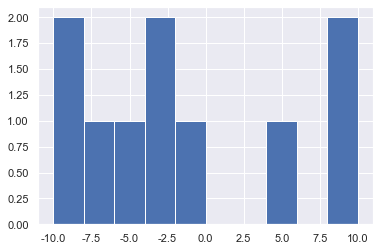

In [1252]:
day_wealth_nn = simulate_k_days(10, 50, dealer_dist_prior, infer_dealer_dist='nn_is')
plt.hist(day_wealth_nn)

In [1253]:
day_wealth_nn

[-10, -10, 10, -3, 4, -5, -2, -7, 8, -3]

In [ ]:
day_wealth_is = simulate_k_days(10, 50, dealer_dist_prior, infer_dealer_dist='is')
plt.hist(day_wealth_is)